### Интерпретация алгоритма оптимизации Adam 
### ЛОгистическая регресия
### Реализация нескольких нейросетей ( какие архитектуры?)


In [1]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from time import *

### Пишем Adam и применяем его к логистической регрессии 


План:

1. Написать свой собственный оптимизатор Adam.
2. Обучить логистическую регрессию побатчево на картинках из датасета.


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [2]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

 Реализация Adam:

In [3]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)
        
        
    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        for param in filter(lambda x: x.grad is not None, group['params']):
            self._init_adam_buffer(param)
            d_param = param.grad
            buffer_m, buffer_v, buffer_s = self._get_adam_buffer(param)
            buffer_s.add_(1)
            buffer_m = (buffer_m * beta_1 + (1 - beta_1) * d_param)/(1 - beta_1 ** buffer_s)
            buffer_v = (buffer_v * beta_2 + (1 - beta_2) * (d_param ** 2))/(1 - beta_2 ** buffer_s)
            d_param = buffer_m / (torch.sqrt(buffer_v) + eps)
            # Inplace update of params multiplied by -lr
            param.add_(d_param, alpha=-lr)

            
    def _get_adam_buffer(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradients for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        param_state = self.state[param]
        return param_state['adam_buffer_m'], param_state['adam_buffer_v'], param_state['step']
    

    def _init_adam_buffer(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        param_state = self.state[param]
        if 'adam_buffer_m' not in param_state:
            param_state['adam_buffer_m'] = torch.zeros_like(param)
        if 'adam_buffer_v' not in param_state:
            param_state['adam_buffer_v'] = torch.zeros_like(param)
        if 'step' not in param_state:
            param_state['step'] = torch.zeros_like(param)

#### Xavier инициализация: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)


In [6]:
def xavier(n_in, n_out=1):
    u = torch.distributions.uniform.Uniform(-math.sqrt(6)/math.sqrt(n_in + n_out), math.sqrt(6)/math.sqrt(n_in + n_out))
    return torch.Tensor([u.sample() for i in range(n_in * n_out)]).view(n_in, n_out), torch.Tensor([u.sample() for i in range(n_out)])

weights, bias = xavier(784, 10)
bias.requires_grad = True
weights.requires_grad = True

Загрузим данные и создадим даталоадеры:

In [5]:
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.ToTensor()
)
train_dataloader = DataLoader(
    fashion_mnist_train, batch_size=128, shuffle=True, num_workers=1
)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

eval_dataloader = DataLoader(
    fashion_mnist_eval, batch_size=128, num_workers=1
)

In [7]:
optimizer = Adam([weights, bias])
#optimizer = torch.optim.Adam([weights, bias], lr=0.001)
loss_func = nn.CrossEntropyLoss()
torch.cuda._initialized=True

 Функции обучения и тестирования логистических регрессий:

In [8]:
def train_logistic_regression(weights, bias, batch, loss_func, optimizer):
    x_train, y_train = batch
    y_pred = torch.sigmoid((x_train.flatten(1)) @ weights + bias)
    loss = loss_func(y_pred, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    accuracy = np.mean((torch.argmax(y_pred, dim = -1) == batch[1]).cpu().numpy())
    return loss.item(), accuracy

def test_logistic_regression(weights, bias, batch, loss_func, optimizer):
    x_train, y_train = batch
    y_pred = torch.sigmoid((x_train.flatten(1)) @ weights + bias)
    loss = loss_func(y_pred, y_train)
    accuracy = np.mean((torch.argmax(y_pred, dim = -1) == batch[1]).cpu().numpy())
    return loss.item(), accuracy

In [9]:
all_train_losses = []
all_train_accuracies = []
all_test_losses = []
all_test_accuracies = []
iterations = 0
test_data = iter(eval_dataloader)
for epoch in range(1, 100):
    print('Train epoch: ', epoch)
    with tqdm(total=len(iter(train_dataloader)), file=sys.stdout) as prbar:
        for batch in train_dataloader:
            loss, accuracy = train_logistic_regression(weights, bias, batch, loss_func, optimizer)
            all_train_losses.append(loss)
            all_train_accuracies.append(accuracy)
            iterations += 1
            prbar.set_description(
                f"Loss: {round(loss, 4)} "
                f"Accuracy: {round(accuracy, 4)}"
            )
            prbar.update(1)
    print('Test epoch: ', epoch)
    with tqdm(total=len(iter(eval_dataloader)), file=sys.stdout) as prbar, torch.no_grad():
        for batch in eval_dataloader:
            loss, accuracy = test_logistic_regression(weights, bias, batch, loss_func, optimizer)
            all_test_losses.append(loss)
            all_test_accuracies.append(accuracy)
            prbar.set_description(
                f"Loss: {round(loss, 4)} "
                f"Accuracy: {round(accuracy, 4)}"
            )
            prbar.update(1)
            
            

Train epoch:  1
Loss: 1.6139 Accuracy: 0.8438: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 72.12it/s]
Test epoch:  1
Loss: 1.5908 Accuracy: 0.8125: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.14it/s]
Train epoch:  2
Loss: 1.6718 Accuracy: 0.7188: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 70.69it/s]
Test epoch:  2
Loss: 1.5568 Accuracy: 0.8125: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 51.95it/s]
Train epoch:  3
Loss: 1.6048 Accuracy: 0.8021: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 77.34it/s]
Test epoch:  3
Loss: 1.5493 Accuracy: 0.8125: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 52.17it/s]
Train epoch:  4
Loss: 1.5963 Accuracy: 0.7917: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 77.23it/s]
Test epoch:  4
Loss: 1.5232 Accuracy: 0.75: 100%|███████████████████████

Loss: 1.6449 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.18it/s]
Train epoch:  32
Loss: 1.7026 Accuracy: 0.7812: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 79.41it/s]
Test epoch:  32
Loss: 1.6457 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 51.03it/s]
Train epoch:  33
Loss: 1.7017 Accuracy: 0.75: 100%|████████████████████████████████████████████████| 469/469 [00:06<00:00, 69.22it/s]
Test epoch:  33
Loss: 1.6482 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.08it/s]
Train epoch:  34
Loss: 1.6742 Accuracy: 0.8333: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 78.60it/s]
Test epoch:  34
Loss: 1.6488 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.14it/s]
Train epoch:  35
Loss: 1.6257 Accuracy: 0.8333: 100%|█████████████████████████████

Loss: 1.6955 Accuracy: 0.7812: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 76.78it/s]
Test epoch:  62
Loss: 1.6449 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.50it/s]
Train epoch:  63
Loss: 1.6194 Accuracy: 0.8333: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 78.03it/s]
Test epoch:  63
Loss: 1.6449 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.69it/s]
Train epoch:  64
Loss: 1.6963 Accuracy: 0.7917: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 75.81it/s]
Test epoch:  64
Loss: 1.6449 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 50.94it/s]
Train epoch:  65
Loss: 1.698 Accuracy: 0.75: 100%|█████████████████████████████████████████████████| 469/469 [00:06<00:00, 72.56it/s]
Test epoch:  65
Loss: 1.6449 Accuracy: 0.875: 100%|███████████████████████████████

Loss: 1.6449 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.43it/s]
Train epoch:  93
Loss: 1.6153 Accuracy: 0.8438: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 70.83it/s]
Test epoch:  93
Loss: 1.6449 Accuracy: 0.8125: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.31it/s]
Train epoch:  94
Loss: 1.6727 Accuracy: 0.7812: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 74.41it/s]
Test epoch:  94
Loss: 1.6449 Accuracy: 0.8125: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.75it/s]
Train epoch:  95
Loss: 1.6831 Accuracy: 0.8333: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 75.91it/s]
Test epoch:  95
Loss: 1.6449 Accuracy: 0.8125: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 52.09it/s]
Train epoch:  96
Loss: 1.6555 Accuracy: 0.8333: 100%|█████████████████████████████

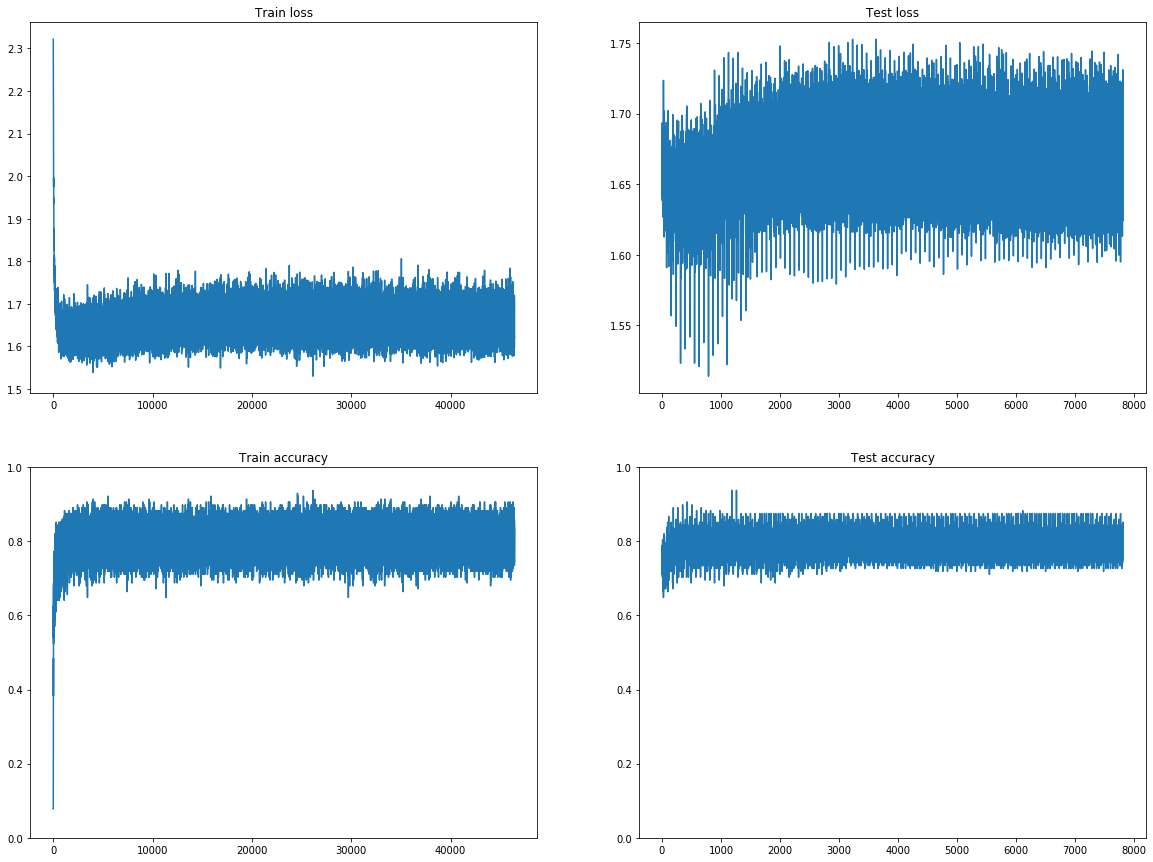

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0, 0].plot(all_train_losses)
axs[0, 0].set_title('Train loss')
axs[0, 1].plot(all_test_losses)
axs[0, 1].set_title('Test loss')
axs[1, 0].plot(all_train_accuracies)
axs[1, 0].set_title('Train accuracy')
axs[1, 0].set_ylim([0, 1])
axs[1, 1].plot(all_test_accuracies)
axs[1, 1].set_ylim([0, 1])
axs[1, 1].set_title('Test accuracy')
plt.show()

<i><b> Модель стала переобучаться примерно на 10 эпохе.<br> </b></i> 
Это можно понять проанализировав график метрик. 
К примеру значения функции потерь начинают расти после примерно 5000 итераций, в батче 128 объектов, в датасете 60000 объектов.<br>
Следовательно : 128*5000/60000 ~ 10 эпоха.

## Нейросети
#### План:
* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать разные оптимизаторы: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели 

* Сделать выводы

In [14]:
def train_model(model, dataloader, optimizer, test_dataloader=None):
    device='cuda:0'
    loss_func = nn.CrossEntropyLoss()
    torch.cuda._initialized = True
    total_train_losses = []
    total_train_accuracies = []
    total_test_losses = []
    total_test_accuracies = []
    iterations = 0
    for epoch in range(0, 100):
        print('Train epoch:', epoch)
        with tqdm(total=len(iter(dataloader)), file=sys.stdout) as prbar:
            for batch in dataloader:
                batch = [x.to(device=device) for x in batch]
                output = model(batch[0])
                loss = loss_func(output, batch[1])
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                accuracy = np.mean((torch.argmax(output, dim = -1) == batch[1]).cpu().numpy())
                total_train_losses.append(loss.item())
                total_train_accuracies.append(accuracy)
                
                prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy, 4)}"
                )
                prbar.update(1)
        if test_dataloader is not None:
            print('Test epoch: ', epoch)
            with tqdm(total=len(iter(test_dataloader)), file=sys.stdout) as prbar, torch.no_grad():
                for batch in test_dataloader:
                    batch = [x.to(device=device) for x in batch]
                    output = model(batch[0])
                    loss = loss_func(output, batch[1])
                    accuracy = np.mean((torch.argmax(output, dim = -1) == batch[1]).cpu().numpy())
                    total_test_losses.append(loss.item())
                    total_test_accuracies.append(accuracy)
                    prbar.set_description(
                        f"Loss: {round(loss.item(), 4)} "
                        f"Accuracy: {round(accuracy, 4)}"
                    )
                    prbar.update(1)
            
    return total_train_losses, total_train_accuracies, total_test_losses, total_test_accuracies, iterations



VGG-подобная архитектура:

In [15]:
class FirstModel(nn.Module):
    def __init__(self, dropout=0.4):
        super().__init__()
        
        self.batch_norm = nn.BatchNorm2d(1)
        self.conv1 = nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.linear1 = nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=64)
        self.linear3 = nn.Linear(in_features=64, out_features=10)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # TODO:
        # Your code here:
        # --------------
        x = self.batch_norm(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return torch.softmax(x, dim=-1)
        # --------------

Resnet-подобная нейросеть:

In [16]:
second_model = nn.Sequential(
    nn.Conv2d(1, 14, 3, padding=1),
    nn.BatchNorm2d(14),
    nn.ReLU(),
    nn.Conv2d(14, 14, 3, padding=1),
    nn.BatchNorm2d(14),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(14, 28, 3, padding=1),
    nn.BatchNorm2d(28),
    nn.ReLU(),
    nn.Conv2d(28, 28, 3, padding=1),
    nn.BatchNorm2d(28),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(28, 56, 3, padding=1),
    nn.BatchNorm2d(56),
    nn.ReLU(),
    nn.Conv2d(56, 56, 3, padding=1),
    nn.BatchNorm2d(56),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Flatten(),
    nn.Linear(56 * 9, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10),
    nn.Softmax(dim=-1)
)


Простая полносвязная сеть:

In [17]:
from collections import OrderedDict
third_model = torch.nn.Sequential(
    OrderedDict([
       ('flatten', nn.Flatten()),
       ('linear_1', nn.Linear(784, 128)),
       ('relu', torch.nn.ReLU()),
       ('linear_2', nn.Linear(128, 10)),
       ('softmax', nn.Softmax(dim=-1))]))

In [18]:
# train and visualize and write summary down there
torch.cuda._initialized = True
device = 'cuda:0'

In [19]:
model1 = FirstModel().to(device=device)
optim_SGD = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
total_train_losses_1, total_train_accuracies_1, total_test_losses_1, total_test_accuracies_1, iterations_1 = train_model(model1, train_dataloader, optim_SGD, eval_dataloader)

Train epoch: 0
Loss: 1.7474 Accuracy: 0.7083: 100%|██████████████████████████████████████████████| 469/469 [00:10<00:00, 46.04it/s]
Test epoch:  0
Loss: 1.6365 Accuracy: 0.8125: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 50.69it/s]
Train epoch: 1
Loss: 1.7658 Accuracy: 0.6979: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 77.45it/s]
Test epoch:  1
Loss: 1.585 Accuracy: 0.875: 100%|██████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.64it/s]
Train epoch: 2
Loss: 1.6697 Accuracy: 0.7917: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 78.26it/s]
Test epoch:  2
Loss: 1.5802 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 52.59it/s]
Train epoch: 3
Loss: 1.6459 Accuracy: 0.8229: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 76.47it/s]
Test epoch:  3
Loss: 1.5809 Accuracy: 0.875: 100%|██████████████████████████

Loss: 1.5396 Accuracy: 0.9375: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 52.09it/s]
Train epoch: 31
Loss: 1.5184 Accuracy: 0.9479: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 77.87it/s]
Test epoch:  31
Loss: 1.6142 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 52.70it/s]
Train epoch: 32
Loss: 1.5318 Accuracy: 0.9271: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 79.30it/s]
Test epoch:  32
Loss: 1.5794 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.25it/s]
Train epoch: 33
Loss: 1.5659 Accuracy: 0.8854: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 77.02it/s]
Test epoch:  33
Loss: 1.5842 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.47it/s]
Train epoch: 34
Loss: 1.5084 Accuracy: 0.9479: 100%|█████████████████████████████████

Loss: 1.5934 Accuracy: 0.8646: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 75.37it/s]
Test epoch:  61
Loss: 1.5278 Accuracy: 0.9375: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.11it/s]
Train epoch: 62
Loss: 1.5414 Accuracy: 0.9167: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 79.26it/s]
Test epoch:  62
Loss: 1.6459 Accuracy: 0.8125: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 50.37it/s]
Train epoch: 63
Loss: 1.5439 Accuracy: 0.9167: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 75.13it/s]
Test epoch:  63
Loss: 1.6465 Accuracy: 0.8125: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 51.59it/s]
Train epoch: 64
Loss: 1.5437 Accuracy: 0.9167: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 75.96it/s]
Test epoch:  64
Loss: 1.6013 Accuracy: 0.875: 100%|██████████████████████████████████

Loss: 1.5241 Accuracy: 0.9375: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.43it/s]
Train epoch: 92
Loss: 1.5238 Accuracy: 0.9375: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 76.52it/s]
Test epoch:  92
Loss: 1.5862 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.04it/s]
Train epoch: 93
Loss: 1.4974 Accuracy: 0.9688: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 76.06it/s]
Test epoch:  93
Loss: 1.6137 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.89it/s]
Train epoch: 94
Loss: 1.4922 Accuracy: 0.9688: 100%|██████████████████████████████████████████████| 469/469 [00:06<00:00, 77.53it/s]
Test epoch:  94
Loss: 1.5531 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.11it/s]
Train epoch: 95
Loss: 1.4813 Accuracy: 0.9792: 100%|█████████████████████████████████

In [20]:
model2 = second_model.to(device=device)
optim_RMSProp = torch.optim.RMSprop(model2.parameters())
total_train_losses_2, total_train_accuracies_2, total_test_losses_2, total_test_accuracies_2, iterations_2 = train_model(model2, train_dataloader, optim_RMSProp, eval_dataloader)

Train epoch: 0
Loss: 1.6764 Accuracy: 0.7812: 100%|██████████████████████████████████████████████| 469/469 [00:10<00:00, 45.69it/s]
Test epoch:  0
Loss: 1.5658 Accuracy: 0.9375: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.92it/s]
Train epoch: 1
Loss: 1.6044 Accuracy: 0.8438: 100%|██████████████████████████████████████████████| 469/469 [00:09<00:00, 48.75it/s]
Test epoch:  1
Loss: 1.7688 Accuracy: 0.6875: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 51.70it/s]
Train epoch: 2
Loss: 1.6316 Accuracy: 0.8333: 100%|██████████████████████████████████████████████| 469/469 [00:09<00:00, 49.15it/s]
Test epoch:  2
Loss: 1.5808 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.75it/s]
Train epoch: 3
Loss: 1.5838 Accuracy: 0.875: 100%|███████████████████████████████████████████████| 469/469 [00:09<00:00, 48.45it/s]
Test epoch:  3
Loss: 1.7104 Accuracy: 0.75: 100%|███████████████████████████

Loss: 1.7111 Accuracy: 0.75: 100%|██████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.91it/s]
Train epoch: 31
Loss: 1.586 Accuracy: 0.875: 100%|████████████████████████████████████████████████| 469/469 [00:09<00:00, 48.28it/s]
Test epoch:  31
Loss: 1.6433 Accuracy: 0.8125: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.85it/s]
Train epoch: 32
Loss: 1.5341 Accuracy: 0.9271: 100%|██████████████████████████████████████████████| 469/469 [00:09<00:00, 48.48it/s]
Test epoch:  32
Loss: 1.5891 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.17it/s]
Train epoch: 33
Loss: 1.5831 Accuracy: 0.875: 100%|███████████████████████████████████████████████| 469/469 [00:09<00:00, 48.15it/s]
Test epoch:  33
Loss: 1.5859 Accuracy: 0.875: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.57it/s]
Train epoch: 34
Loss: 1.5093 Accuracy: 0.9479: 100%|█████████████████████████████████

Loss: 1.5653 Accuracy: 0.8958: 100%|██████████████████████████████████████████████| 469/469 [00:09<00:00, 48.03it/s]
Test epoch:  61
Loss: 1.5237 Accuracy: 0.9375: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.83it/s]
Train epoch: 62
Loss: 1.5341 Accuracy: 0.9271: 100%|██████████████████████████████████████████████| 469/469 [00:09<00:00, 48.41it/s]
Test epoch:  62
Loss: 1.5237 Accuracy: 0.9375: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.71it/s]
Train epoch: 63
Loss: 1.6354 Accuracy: 0.8229: 100%|██████████████████████████████████████████████| 469/469 [00:09<00:00, 48.02it/s]
Test epoch:  63
Loss: 1.524 Accuracy: 0.9375: 100%|█████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.19it/s]
Train epoch: 64
Loss: 1.5213 Accuracy: 0.9375: 100%|██████████████████████████████████████████████| 469/469 [00:09<00:00, 48.42it/s]
Test epoch:  64
Loss: 1.4612 Accuracy: 1.0: 100%|████████████████████████████████████

Loss: 1.5237 Accuracy: 0.9375: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.13it/s]
Train epoch: 92
Loss: 1.5966 Accuracy: 0.8646: 100%|██████████████████████████████████████████████| 469/469 [00:09<00:00, 49.60it/s]
Test epoch:  92
Loss: 1.5237 Accuracy: 0.9375: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.18it/s]
Train epoch: 93
Loss: 1.5465 Accuracy: 0.9167: 100%|██████████████████████████████████████████████| 469/469 [00:09<00:00, 49.37it/s]
Test epoch:  93
Loss: 1.5237 Accuracy: 0.9375: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.18it/s]
Train epoch: 94
Loss: 1.5653 Accuracy: 0.8958: 100%|██████████████████████████████████████████████| 469/469 [00:09<00:00, 49.66it/s]
Test epoch:  94
Loss: 1.5237 Accuracy: 0.9375: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.44it/s]
Train epoch: 95
Loss: 1.5654 Accuracy: 0.8958: 100%|█████████████████████████████████

In [21]:
model3 = third_model.to(device=device)
optim_RMSProp = torch.optim.RMSprop(model3.parameters())
total_train_losses_3, total_train_accuracies_3, total_test_losses_3, total_test_accuracies_3, iterations_3 = train_model(model3, train_dataloader, optim_SGD, eval_dataloader)

Train epoch: 0
Loss: 2.3032 Accuracy: 0.0833: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 81.10it/s]
Test epoch:  0
Loss: 2.3039 Accuracy: 0.0625: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.10it/s]
Train epoch: 1
Loss: 2.3046 Accuracy: 0.0625: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 81.06it/s]
Test epoch:  1
Loss: 2.3039 Accuracy: 0.0625: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.29it/s]
Train epoch: 2
Loss: 2.3053 Accuracy: 0.1146: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 80.49it/s]
Test epoch:  2
Loss: 2.3039 Accuracy: 0.0625: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.56it/s]
Train epoch: 3
Loss: 2.3061 Accuracy: 0.1042: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 81.08it/s]
Test epoch:  3
Loss: 2.3039 Accuracy: 0.0625: 100%|█████████████████████████

Loss: 2.3039 Accuracy: 0.0625: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.30it/s]
Train epoch: 31
Loss: 2.3062 Accuracy: 0.0729: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 81.58it/s]
Test epoch:  31
Loss: 2.3039 Accuracy: 0.0625: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.49it/s]
Train epoch: 32
Loss: 2.3069 Accuracy: 0.0729: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 81.34it/s]
Test epoch:  32
Loss: 2.3039 Accuracy: 0.0625: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.75it/s]
Train epoch: 33
Loss: 2.3037 Accuracy: 0.1146: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 81.66it/s]
Test epoch:  33
Loss: 2.3039 Accuracy: 0.0625: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.05it/s]
Train epoch: 34
Loss: 2.3064 Accuracy: 0.0729: 100%|█████████████████████████████████

Loss: 2.3039 Accuracy: 0.1146: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 79.25it/s]
Test epoch:  61
Loss: 2.3039 Accuracy: 0.0625: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.63it/s]
Train epoch: 62
Loss: 2.3057 Accuracy: 0.125: 100%|███████████████████████████████████████████████| 469/469 [00:05<00:00, 79.85it/s]
Test epoch:  62
Loss: 2.3039 Accuracy: 0.0625: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.43it/s]
Train epoch: 63
Loss: 2.3055 Accuracy: 0.0729: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 79.87it/s]
Test epoch:  63
Loss: 2.3039 Accuracy: 0.0625: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.08it/s]
Train epoch: 64
Loss: 2.3036 Accuracy: 0.1042: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 79.28it/s]
Test epoch:  64
Loss: 2.3039 Accuracy: 0.0625: 100%|█████████████████████████████████

Loss: 2.3039 Accuracy: 0.0625: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.63it/s]
Train epoch: 92
Loss: 2.306 Accuracy: 0.0729: 100%|███████████████████████████████████████████████| 469/469 [00:05<00:00, 80.34it/s]
Test epoch:  92
Loss: 2.3039 Accuracy: 0.0625: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.55it/s]
Train epoch: 93
Loss: 2.3017 Accuracy: 0.125: 100%|███████████████████████████████████████████████| 469/469 [00:05<00:00, 80.39it/s]
Test epoch:  93
Loss: 2.3039 Accuracy: 0.0625: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.47it/s]
Train epoch: 94
Loss: 2.3051 Accuracy: 0.1042: 100%|██████████████████████████████████████████████| 469/469 [00:05<00:00, 79.91it/s]
Test epoch:  94
Loss: 2.3039 Accuracy: 0.0625: 100%|████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.89it/s]
Train epoch: 95
Loss: 2.306 Accuracy: 0.0833: 100%|██████████████████████████████████

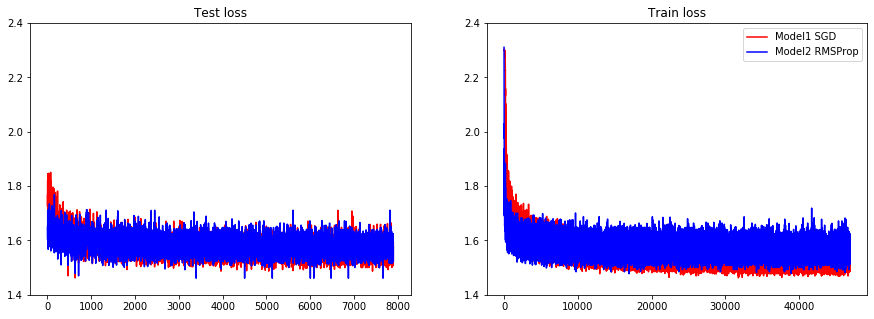

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(total_test_losses_1, label='Model1 SGD', c='red')
axs[0].plot(total_test_losses_2, label='Model2 RMSProp', c='blue')
axs[0].set_ylim([1.4, 2.4])
axs[0].set_title('Test loss')
axs[1].plot(total_train_losses_1, label='Model1 SGD', c='red')
axs[1].plot(total_train_losses_2, label='Model2 RMSProp', c='blue')
axs[1].set_ylim([1.4, 2.4])
axs[1].set_title('Train loss')
plt.legend()
plt.show()

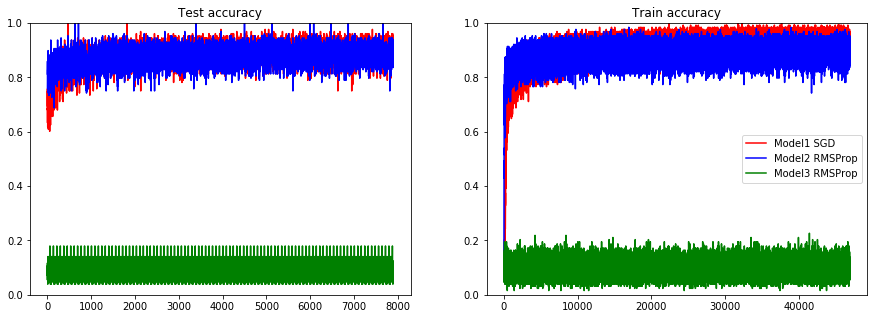

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(total_test_accuracies_1, label='Model1 SGD', c='red')
axs[0].plot(total_test_accuracies_2, label='Model2 RMSProp', c='blue')
axs[0].plot(total_test_accuracies_3, label='Model3 RMSProp', c='green')
axs[0].set_ylim([0, 1])
axs[0].set_title('Test accuracy')
axs[1].plot(total_train_accuracies_1, label='Model1 SGD', c='red')
axs[1].plot(total_train_accuracies_2, label='Model2 RMSProp', c='blue')
axs[1].plot(total_train_accuracies_3, label='Model3 RMSProp', c='green')
axs[1].set_ylim([0, 1])
axs[1].set_title('Train accuracy')
plt.legend()
plt.show()

## Выводы: 
* Третья модель показала наихудший результат, очевидно сети с малым количеством слоёв не способны выявить такие сложные закономерности, как классификация изображений на 10 классов.
* Первая модель обученная методом стохастического градиентного спуска дала лучший результат, наиболее вероятно, что на лучший результат повлияла скорее архитектура сети нежели метод оптимизации.
* При этом по графикам метрик видно, что RMSProp быстрее спускается по функции потерь на первых 8-9 эпохах, а после начинает уступать в скорости.
* Главный вывод состоит в том, что первостепенную роль играет архитектура сети, а потом уже оптимизатор, который не способен исправить недостатки плохой/неподходящей архитектуры.